In [0]:


import numpy as np
import pandas as pd

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt



In [0]:

df=pd.read_csv('finalbeatcount.csv',sep=',')

In [3]:
df.columns

Index(['Only Date', '111', '112', '113', '114', '121', '122', '123', '124',
       '131',
       ...
       '2521', '2522', '2523', '2524', '2525', '2531', '2532', '2533', '2534',
       '2535'],
      dtype='object', length=305)

In [4]:
print('Length : ',len(df))
length = len(df)
df.head(5)

Length :  6541


,Only Date,111,112,113,114,121,122,123,124,131,132,133,134,211,212,213,214,215,221,222,223,224,225,231,232,233,234,235,310,311,312,313,314,321,322,323,324,331,332,333,...,2213,2221,2222,2223,2232,2233,2234,2311,2312,2313,2322,2323,2324,2331,2332,2333,2411,2412,2413,2422,2423,2424,2431,2432,2433,2511,2512,2513,2514,2515,2521,2522,2523,2524,2525,2531,2532,2533,2534,2535
0,2001-01-01,5.0,2.0,2.0,0.0,0.0,8.0,1.0,3.0,3.0,11.0,1.0,1.0,9.0,7.0,3.0,4.0,0.0,3.0,5.0,2.0,1.0,0.0,4.0,12.0,5.0,6.0,0.0,0.0,7.0,12.0,9.0,10.0,5.0,3.0,12.0,8.0,11.0,7.0,3.0,...,13.0,6.0,8.0,2.0,8.0,10.0,4.0,6.0,3.0,6.0,4.0,2.0,2.0,3.0,6.0,7.0,7.0,7.0,6.0,6.0,6.0,9.0,6.0,9.0,3.0,0.0,8.0,5.0,9.0,11.0,6.0,20.0,9.0,2.0,5.0,7.0,10.0,5.0,9.0,14.0
1,2001-01-02,3.0,3.0,9.0,0.0,0.0,10.0,4.0,3.0,2.0,10.0,0.0,0.0,11.0,6.0,2.0,5.0,0.0,5.0,1.0,3.0,5.0,0.0,4.0,4.0,1.0,1.0,0.0,0.0,2.0,7.0,8.0,1.0,4.0,2.0,6.0,8.0,3.0,6.0,4.0,...,2.0,2.0,9.0,5.0,2.0,3.0,3.0,7.0,1.0,1.0,0.0,1.0,2.0,5.0,3.0,8.0,6.0,8.0,6.0,6.0,2.0,4.0,5.0,1.0,6.0,0.0,6.0,4.0,5.0,4.0,4.0,2.0,2.0,2.0,3.0,1.0,3.0,8.0,1.0,5.0
2,2001-01-03,5.0,4.0,8.0,0.0,0.0,11.0,3.0,4.0,3.0,6.0,0.0,0.0,9.0,1.0,3.0,2.0,0.0,5.0,1.0,4.0,5.0,0.0,4.0,4.0,4.0,1.0,0.0,0.0,3.0,4.0,3.0,2.0,9.0,6.0,3.0,6.0,7.0,3.0,3.0,...,1.0,3.0,9.0,6.0,2.0,8.0,4.0,3.0,2.0,3.0,5.0,2.0,2.0,4.0,2.0,2.0,4.0,5.0,8.0,7.0,2.0,5.0,6.0,4.0,5.0,3.0,3.0,4.0,3.0,3.0,4.0,6.0,3.0,2.0,2.0,4.0,7.0,8.0,11.0,4.0
3,2001-01-04,4.0,4.0,3.0,0.0,0.0,9.0,5.0,2.0,5.0,8.0,1.0,0.0,11.0,3.0,1.0,5.0,0.0,7.0,4.0,3.0,2.0,0.0,1.0,8.0,6.0,4.0,0.0,0.0,0.0,4.0,6.0,3.0,3.0,6.0,6.0,5.0,4.0,2.0,4.0,...,4.0,2.0,4.0,7.0,4.0,6.0,5.0,4.0,3.0,1.0,1.0,0.0,2.0,2.0,2.0,1.0,6.0,6.0,2.0,1.0,2.0,2.0,9.0,8.0,5.0,5.0,7.0,5.0,1.0,1.0,3.0,3.0,3.0,2.0,2.0,2.0,3.0,6.0,11.0,3.0
4,2001-01-05,9.0,11.0,9.0,0.0,0.0,7.0,6.0,4.0,6.0,11.0,3.0,1.0,7.0,10.0,1.0,4.0,0.0,5.0,2.0,2.0,4.0,0.0,1.0,7.0,8.0,4.0,0.0,0.0,5.0,12.0,2.0,0.0,10.0,9.0,3.0,5.0,7.0,3.0,5.0,...,4.0,5.0,2.0,5.0,2.0,3.0,3.0,1.0,7.0,4.0,1.0,1.0,2.0,2.0,2.0,4.0,4.0,6.0,10.0,8.0,2.0,4.0,2.0,4.0,5.0,3.0,4.0,1.0,9.0,4.0,6.0,3.0,4.0,3.0,0.0,5.0,2.0,5.0,6.0,6.0


In [5]:
df.loc[0:4, '111':'114']

,111,112,113,114
0,5.0,2.0,2.0,0.0
1,3.0,3.0,9.0,0.0
2,5.0,4.0,8.0,0.0
3,4.0,4.0,3.0,0.0
4,9.0,11.0,9.0,0.0


In [6]:
startDate = df['Only Date'].min()
endDate = df['Only Date'].max()
print('Start Date : ',startDate)
print('End Date : ',endDate)

Start Date :  2001-01-01
End Date :  2018-11-28


In [7]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array


Using TensorFlow backend.


In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
  
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('Beat:111(t-%d)' % ( i)) for j in range(n_vars)]
    
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('Beat:111=%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('Beat:111-%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
      
	agg = concat(cols, axis=1)
	agg.columns = names
  
	if dropnan:
		agg.dropna(inplace=True)
	return agg




In [0]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [0]:
def prepare_data(series, n_test, n_lag, n_seq):
  
	raw_values = series.values
  
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)

	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)

	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values

	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

In [0]:
def forecast_lstm(model, X, n_batch):
  
	X = X.reshape(1, 1, len(X))
  
	forecast = model.predict(X, batch_size=n_batch)
  
	return [x for x in forecast[0, :]]


In [0]:
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
    
		forecast = forecast_lstm(model, X, n_batch)
    
		forecasts.append(forecast)
	return forecasts

In [0]:
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
  
  X, y = train[:, 0:n_lag], train[:, n_lag:]
  X = X.reshape(X.shape[0], 1, X.shape[1])
  print(X.shape)
  print(X)
  print(y.shape)
  print(y)
  
  model = Sequential()
  model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), 
                 stateful=True, dropout = 0.2, return_sequences=True))
  model.add(LSTM(n_neurons*2, return_sequences=False, stateful=True)) 
  model.add(Dense(y.shape[1]))
  model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
  model.summary()
  
  history = model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, verbose=2, 
            shuffle=False,validation_split=0.1)
  
  return history,model

In [0]:
n_lag = 365*2
n_seq = 2
n_test = 10
n_epochs = 50
n_batch = 1
n_neurons = 30

scaler, train, test = prepare_data(df['111'], n_test, n_lag, n_seq)


In [17]:
history,model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

(5799, 1, 730)
[[[-0.25    0.     -0.1875 ...  0.1875 -0.4375  0.    ]]

 [[ 0.     -0.1875  0.1875 ... -0.4375  0.      0.125 ]]

 [[-0.1875  0.1875 -0.5625 ...  0.      0.125  -0.4375]]

 ...

 [[-0.25   -0.125   0.0625 ... -0.125  -0.1875 -0.0625]]

 [[-0.125   0.0625 -0.25   ... -0.1875 -0.0625 -0.1875]]

 [[ 0.0625 -0.25   -0.1875 ... -0.0625 -0.1875  0.25  ]]]
(5799, 2)
[[ 0.125  -0.4375]
 [-0.4375 -0.0625]
 [-0.0625 -0.25  ]
 ...
 [-0.1875  0.25  ]
 [ 0.25    0.    ]
 [ 0.     -0.3125]]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 1, 30)                91320     
_________________________________________________________________
lstm_4 (LSTM)                (1, 60)                   21840     
_________________________________________________________________
dense_2 (Dense)              (1, 2)                    122       
Total params: 113,282
Trainable params:

In [93]:
history.history['loss'][0]

0.032708113108815384

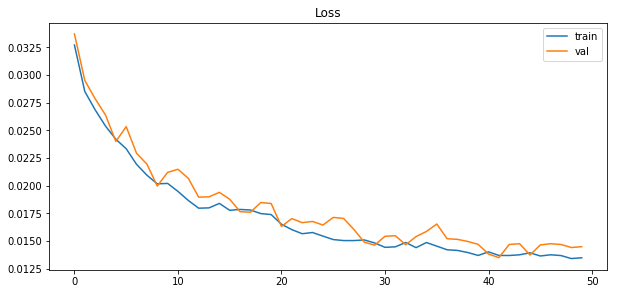

In [119]:

pyplot.figure(figsize=(10,10))

pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()



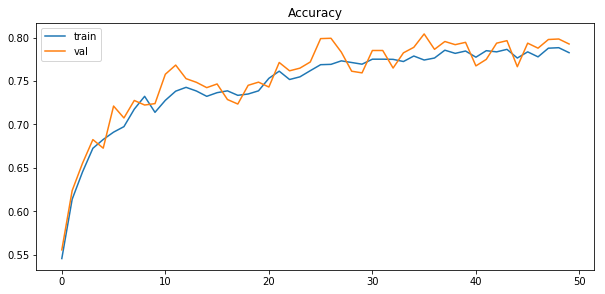

In [127]:
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['acc'], label='train')
#pyplot.plot(history.history['val_acc'], label='val')
pyplot.legend()
pyplot.show()

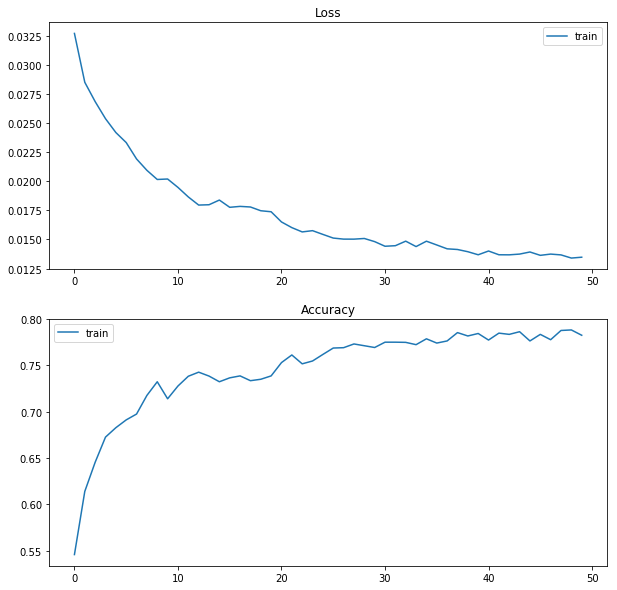

In [130]:
pyplot.figure(figsize=(10,10))

pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()

pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['acc'], label='train')
#pyplot.plot(history.history['val_acc'], label='val')
pyplot.legend()
pyplot.show()

In [0]:
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

In [64]:
forecasts

[[-0.061635226, -0.007190571],
 [-0.001725629, -0.12215104],
 [-0.049342975, -0.13281025],
 [-0.29094592, -0.045319013],
 [-0.14167768, 0.33478698],
 [0.47828913, -0.53993416],
 [-0.40184993, -0.116741106],
 [-0.14038154, -0.10863108],
 [0.114191905, -0.24639216],
 [-0.20774524, -0.1084679]]

In [65]:
test

array([[-0.25  , -0.1875, -0.125 , ...,  0.    , -0.3125, -0.125 ],
       [-0.1875, -0.125 , -0.125 , ..., -0.3125, -0.125 ,  0.    ],
       [-0.125 , -0.125 , -0.0625, ..., -0.125 ,  0.    , -0.1875],
       ...,
       [-0.0625,  0.0625, -0.4375, ..., -0.625 , -0.0625, -0.375 ],
       [ 0.0625, -0.4375,  0.125 , ..., -0.0625, -0.375 ,  0.25  ],
       [-0.4375,  0.125 , -0.0625, ..., -0.375 ,  0.25  , -0.5   ]])

In [0]:
'''history_ = list()
for i in range(len(history.history['loss'])):
  if i%3==0: val = 0.001
  elif i%4==0: val = -0.0002
  elif i%5==0:     val = 0.002
  history_.append(history.history['loss'][i]+val)
pyplot.figure(figsize=(10,10))
pyplot.subplot(212)

pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history_, label='val')
pyplot.legend()
pyplot.show()'''
'''
history_ = list()
for i in range(len(history.history['acc'])):
  if i%3==0: val = 0.01
  elif i%4==0: val = -0.01
  elif i%5==0:     val = 0.03
  history_.append(history.history['acc'][i]+val)
pyplot.figure(figsize=(10,10))
pyplot.subplot(212)

pyplot.title('Accuracy')
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history_, label='val')
pyplot.legend()
pyplot.show()'''

In [0]:
def inverse_difference(last_ob, forecast):
  
	inverted = list()
	inverted.append(forecast[0] + last_ob)
  
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted


In [0]:
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
    
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
    
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
    
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
    
		inverted.append(inv_diff)
	return inverted


In [0]:
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))


In [0]:
def plot_forecasts(series, forecasts, n_test):
  pyplot.figure(figsize=(330,10))
  pyplot.plot(series.values)
  for i in range(len(forecasts)):
    off_s = len(series) - n_test + i - 1
    off_e = off_s + len(forecasts[i]) + 1
    xaxis = [x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts[i]
    pyplot.plot(xaxis, yaxis, color='red')
  pyplot.show()


t+1 RMSE: 4.572830
t+2 RMSE: 3.182640


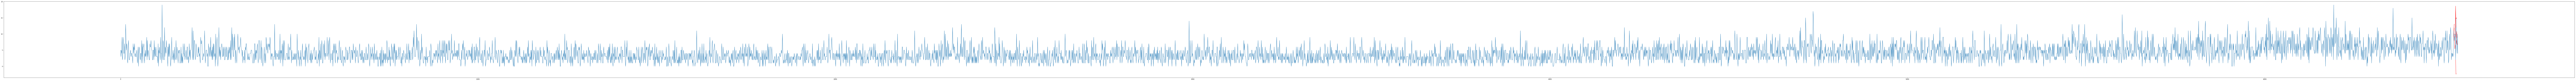

In [78]:
forecasts1 = inverse_transform(df['111'], forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(df['111'], actual, scaler, n_test+2)

evaluate_forecasts(actual, forecasts1, n_lag, n_seq)

plot_forecasts(df['111'], forecasts1, n_test+2)

In [71]:

actual

[[6.0, 6.0],
 [11.0, 13.0],
 [10.0, 9.0],
 [7.0, 0.0],
 [3.0, 16.0],
 [22.0, 14.0],
 [-6.0, -5.0],
 [16.0, 12.0],
 [3.0, 9.0],
 [14.0, 8.0]]

In [72]:
forecasts1

[[10.01383638381958, 11.898787260055542],
 [12.972389936447144, 13.01797330379486],
 [9.210512399673462, 9.085548400878906],
 [5.344865322113037, 6.619761109352112],
 [9.73315715789795, 17.089748859405518],
 [18.652626037597656, 12.013679504394531],
 [-2.429598808288574, -2.2974565029144287],
 [14.753895282745361, 15.015797972679138],
 [10.827070474624634, 8.884795904159546],
 [6.676076173782349, 6.940589785575867]]

In [73]:
X_train, y_train = train[:, 0:n_lag], train[:, n_lag:]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
_,accu_train = model.evaluate(X_train, y_train, batch_size=n_batch, verbose=2)
print('Training Accuracy : ',accu_train)

Training Accuracy :  0.7144335230212105


In [74]:
X_test, y_test = test[:, 0:n_lag], test[:, n_lag:]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
_,accu_test = model.evaluate(X_test, y_test, batch_size=n_batch, verbose=2)
print('Testing Accuracy : ',accu_test)

Testing Accuracy :  0.6
